In [1]:
import sys
from functools import partial
from pathlib import Path
from time import perf_counter
from typing import Callable

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
import torch
import torchvision.transforms.functional as tvtf
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

sys.path.insert(0, "..")
import rihog

In [2]:
DS_PATH = Path("../Original Brodatz")
IMG_SIZE = 128

In [3]:
def get_img_id(fpath: Path):
	return int(fpath.stem[1:])
img_tnsr_list = []
img_lbl_list = []
img_fpath_list = sorted(DS_PATH.iterdir(), key=get_img_id)
for img_fpath in tqdm(img_fpath_list):
	img = Image.open(img_fpath)
	lbl = get_img_id(img_fpath)
	for angle in range(0, 360, 30):
		rot_img = img.rotate(angle=angle, resample=Image.Resampling.BICUBIC)
		rot_img_tnsr = tvtf.to_tensor(rot_img)
		crop_rot_img_tnsr = tvtf.center_crop(rot_img_tnsr, IMG_SIZE)
		img_tnsr_list.append(crop_rot_img_tnsr)
		img_lbl_list.append(lbl)
N_IMG = len(img_fpath_list)
N_ROT = len(img_tnsr_list) // N_IMG
data_imgs = torch.stack(img_tnsr_list)
data_img_bs = einops.rearrange(data_imgs, "(i r) 1 h w -> i r 1 h w", i=N_IMG, r=N_ROT)
data_lbls = torch.tensor(img_lbl_list, dtype=torch.int)
data_lbl_bs = einops.rearrange(data_lbls, "(i r) -> i r", i=N_IMG, r=N_ROT)
data_img_bs.shape, data_lbl_bs.shape

100%|██████████| 112/112 [00:06<00:00, 16.13it/s]


(torch.Size([112, 12, 1, 128, 128]), torch.Size([112, 12]))

In [4]:
def compute_hog(fextr: Callable[[np.ndarray], np.ndarray], img_bs: torch.Tensor):
	img_avg_hog_list = []
	tot_time = 0
	for img_b in img_bs.numpy(force=True):
		for img in img_b:
			s_time = perf_counter()
			img_hog = fextr(img[0])  # (vb hb vc hc f)
			tot_time += perf_counter() - s_time
			img_avg_hog = img_hog.mean(axis=(0, 1, 2, 3))  # (f)
			img_avg_hog_list.append(img_avg_hog)
	hog_feats = np.array(img_avg_hog_list)
	return hog_feats, tot_time

In [5]:
def compute_rihog(fextr: rihog.RIHOG, img_bs: torch.Tensor):
	avg_rihog_b_list = []
	tot_time = 0
	for img_b in img_bs:
		s_time = perf_counter()
		rihog_b = fextr(img_b)  # (b wc f)
		if img_bs.device.type == "cuda":
			torch.cuda.synchronize()
		tot_time += perf_counter() - s_time
		avg_rihog_b = rihog_b.mean(dim=1)  # (b f)
		avg_rihog_b_list.append(avg_rihog_b)
	rihog_feats = torch.cat(avg_rihog_b_list, dim=0).numpy(force=True)
	return rihog_feats, tot_time

In [6]:
def compute_sift(fextr: skimage.feature.SIFT, img_bs: torch.Tensor, lbl_bs: torch.Tensor):
	img_avg_sift_list = []
	lbl_list = []
	tot_time = 0
	for img_b, lbl_b in zip(img_bs.numpy(force=True), lbl_bs.numpy(force=True)):
		for img, lbl in zip(img_b, lbl_b):
			try:
				s_time = perf_counter()
				fextr.detect_and_extract(img[0])
				tot_time += perf_counter() - s_time
			except RuntimeError:
				pass
			else:
				img_sift = fextr.descriptors  # (n f)
				img_avg_sift = img_sift.mean(axis=0)
				img_avg_sift_list.append(img_avg_sift)
				lbl_list.append(lbl)
	sift_feats = np.array(img_avg_sift_list)
	lbls = np.array(lbl_list)
	return sift_feats, lbls, tot_time

In [7]:
knn_clsf = KNeighborsClassifier(weights="distance", metric="cosine")
hog_df_rows = []
rihog_df_rows = []
sift_df_rows = []
for n_train in range(1, 3+1):
	train_lbl_bs, test_lbl_bs = data_lbl_bs[:, :n_train], data_lbl_bs[:, n_train:]
	train_img_bs, test_img_bs = data_img_bs[:, :n_train], data_img_bs[:, n_train:]
	for n_dim in [8, 16, 32]:
		## HOG
		for ppc in [8, 16, 32]:
			hog_fextr = partial(skimage.feature.hog, feature_vector=False, orientations=n_dim, pixels_per_cell=(ppc, ppc))
			hog_train_feats, _ = compute_hog(hog_fextr, train_img_bs)  # (n f)
			hog_test_feats, hog_test_time = compute_hog(hog_fextr, test_img_bs)  # (n f)
			knn_clsf.fit(hog_train_feats, train_lbl_bs.ravel())
			hog_score = knn_clsf.score(hog_test_feats, test_lbl_bs.ravel())
			hog_df_rows.append({
				"n_train": n_train,
				"orientations": n_dim,
				"pixels_per_cell": ppc,
				"score": hog_score,
				"device": "cpu",
				"time": hog_test_time / test_lbl_bs.numel()
			})
		## RIHOG
		for n_bins in filter(lambda x: x <= n_dim, [8, 16, 32]):
			nbhd_steps = n_dim // n_bins
			for rel_magn_mode in rihog.RelativeMagnitudeMode:
				rihog_fextr = rihog.RIHOG(nbhd_steps=nbhd_steps, num_bins=n_bins, rel_magn_mode=rel_magn_mode)
				for device in ["cpu", "cuda"]:
					rihog_train_feats, _ = compute_rihog(rihog_fextr, train_img_bs.to(device))  # (n f)
					rihog_test_feats, rihog_test_time = compute_rihog(rihog_fextr, test_img_bs.to(device))  # (n f)
					knn_clsf.fit(rihog_train_feats, train_lbl_bs.ravel())
					rihog_score = knn_clsf.score(rihog_test_feats, test_lbl_bs.ravel())
					rihog_df_rows.append({
						"n_train": n_train,
						"n_bins": n_bins,
						"nbhd_steps": nbhd_steps,
						"rel_magn_mode": rel_magn_mode,
						"score": rihog_score,
						"device": device,
						"time": rihog_test_time / test_lbl_bs.numel()
					})
		## SIFT
		for n_hist in filter(lambda x: x**2 < n_dim, [1, 2, 4]):
			n_ori = n_dim // (n_hist**2)
			sift_fextr = skimage.feature.SIFT(upsampling=1, n_ori=n_ori)
			sift_train_feats, sift_train_lbls, _ = compute_sift(sift_fextr, train_img_bs, train_lbl_bs)  # (n f), (n)
			sift_test_feats, sift_test_lbls, sift_test_time = compute_sift(sift_fextr, test_img_bs, test_lbl_bs)  # (n f), (n)
			knn_clsf.fit(sift_train_feats, sift_train_lbls)
			sift_score = knn_clsf.score(sift_test_feats, sift_test_lbls) * len(sift_test_lbls) / test_lbl_bs.numel()
			sift_df_rows.append({
				"n_train": n_train,
				"n_hist": n_hist,
				"n_ori": n_ori,
				"score": sift_score,
				"device": "cpu",
				"time": sift_test_time / test_lbl_bs.numel()
			})

In [8]:
df_hog = pd.DataFrame.from_records(hog_df_rows)
df_hog["dim"] = df_hog["orientations"]
df_hog = df_hog.sort_values(["score", "time"], ascending=[False, True]).groupby(["n_train", "dim", "device"]).first().reset_index()
df_rihog = pd.DataFrame.from_records(rihog_df_rows)
df_rihog["dim"] = df_rihog["nbhd_steps"] * df_rihog["n_bins"]
df_rihog = df_rihog.sort_values(["score", "time"], ascending=[False, True]).groupby(["n_train", "dim", "rel_magn_mode", "device"]).first().reset_index()
df_sift = pd.DataFrame.from_records(sift_df_rows)
df_sift["dim"] = df_sift["n_hist"]**2 * df_sift["n_ori"]
df_sift = df_sift.sort_values(["score", "time"], ascending=[False, True]).groupby(["n_train", "dim", "device"]).first().reset_index()
display(df_hog.head())
display(df_rihog.head())
display(df_sift.head())

,n_train,dim,device,orientations,pixels_per_cell,score,time
0,1,8,cpu,8,16,0.108766,0.000988
1,1,16,cpu,16,8,0.120130,0.002691
2,1,32,cpu,32,8,0.126623,0.003382
3,2,8,cpu,8,8,0.239286,0.002278
4,2,16,cpu,16,8,0.251786,0.002711


,n_train,dim,rel_magn_mode,device,n_bins,nbhd_steps,score,time
0,1,8,diff,cpu,8,1,0.424513,0.001244
1,1,8,diff,cuda,8,1,0.422890,0.000082
2,1,8,ratio,cpu,8,1,0.418019,0.001349
3,1,8,ratio,cuda,8,1,0.439935,0.000082
4,1,16,diff,cpu,8,2,0.554383,0.003809


,n_train,dim,device,n_hist,n_ori,score,time
0,1,8,cpu,1,8,0.939935,0.016265
1,1,16,cpu,1,16,0.943182,0.017310
2,1,32,cpu,1,32,0.943994,0.018741
3,2,8,cpu,1,8,0.952679,0.016434
4,2,16,cpu,1,16,0.956250,0.017240


In [9]:
cols = ["n_train", "dim", "algo", "score", "time"]
df_hog["algo"] = "skimage HOG" + " [" + df_hog["device"] + "]"
df_rihog["algo"] = df_rihog["rel_magn_mode"].replace({"diff": "RIHOG1", "ratio": "RIHOG3"}) + " [" + df_rihog["device"] + "]"
df_sift["algo"] = "skimage SIFT" + " [" + df_sift["device"] + "]"
df = pd.concat([df_hog[cols], df_rihog[cols], df_sift[cols]])
df.head()

,n_train,dim,algo,score,time
0,1,8,skimage HOG [cpu],0.108766,0.000988
1,1,16,skimage HOG [cpu],0.120130,0.002691
2,1,32,skimage HOG [cpu],0.126623,0.003382
3,2,8,skimage HOG [cpu],0.239286,0.002278
4,2,16,skimage HOG [cpu],0.251786,0.002711


In [10]:
df_plot = df.melt(id_vars=["n_train", "dim", "algo"], value_vars=["score", "time"])
df_plot.loc[df_plot["variable"]=="score", "value"] = df_plot.loc[df_plot["variable"]=="score", "value"] * 100
df_plot.loc[df_plot["variable"]=="time", "value"] = df_plot.loc[df_plot["variable"]=="time", "value"] * 1000
time_scale = 100 / df_plot.loc[df_plot["variable"]=="time", "value"].max()
df_plot.loc[df_plot["variable"]=="time", "value"] = df_plot.loc[df_plot["variable"]=="time", "value"] * time_scale
df_plot.loc[df_plot["variable"]=="score", "variable"] = "accuracy [%]"
df_plot.loc[df_plot["variable"]=="time", "variable"] = "avg sample time [ms]"
df_plot.head()

,n_train,dim,algo,variable,value
0,1,8,skimage HOG [cpu],accuracy [%],10.876623
1,1,16,skimage HOG [cpu],accuracy [%],12.012987
2,1,32,skimage HOG [cpu],accuracy [%],12.662338
3,2,8,skimage HOG [cpu],accuracy [%],23.928571
4,2,16,skimage HOG [cpu],accuracy [%],25.178571


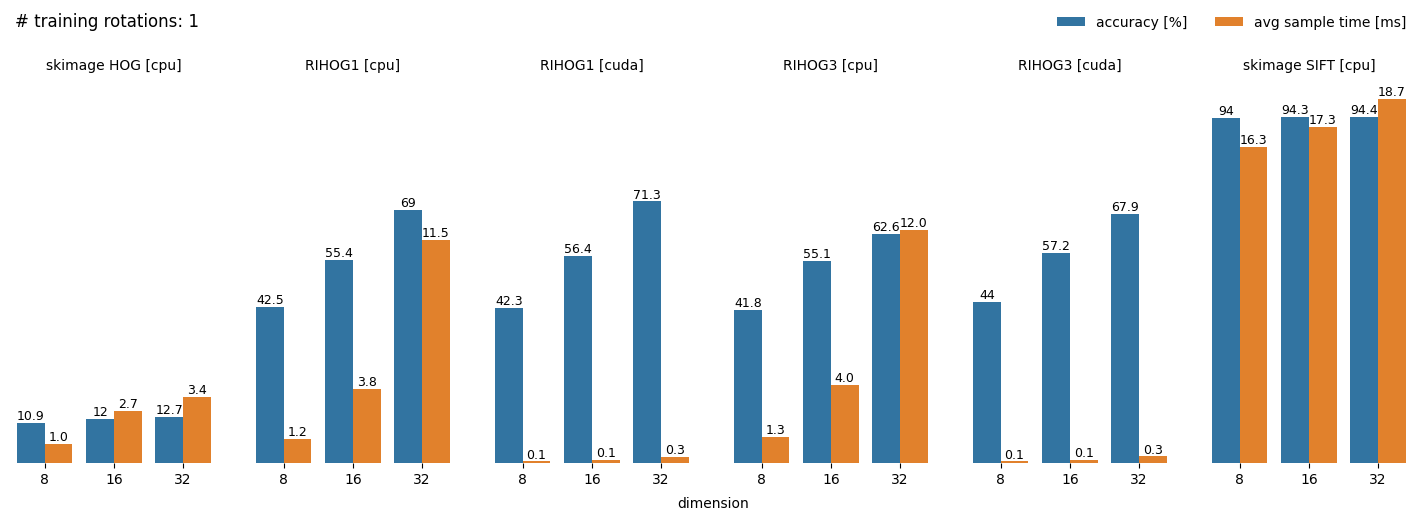

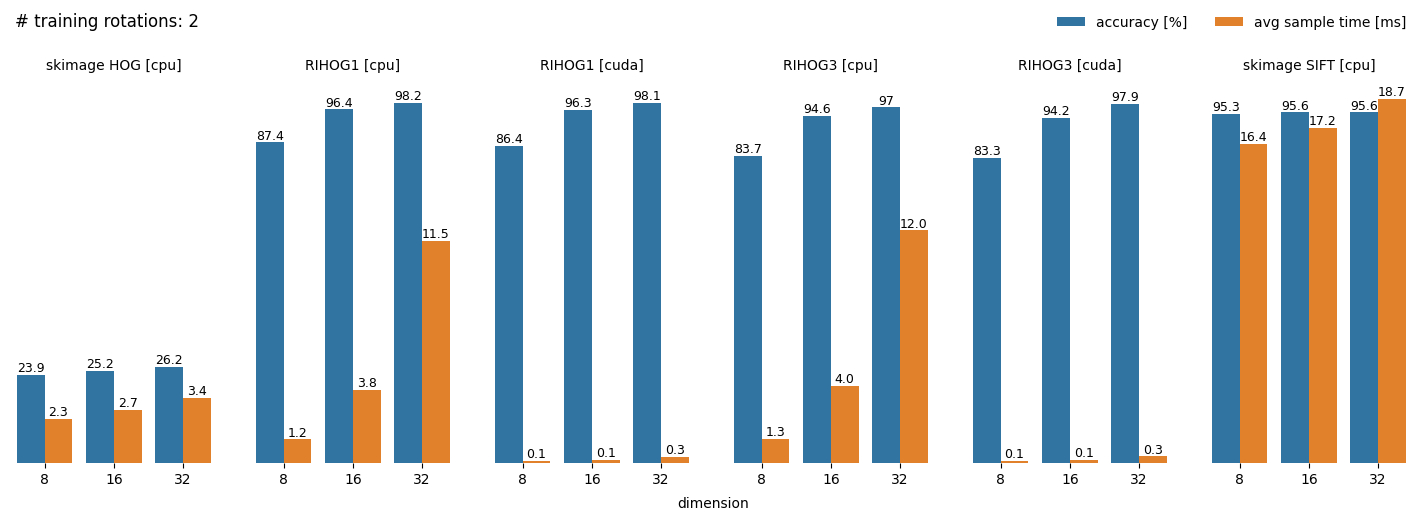

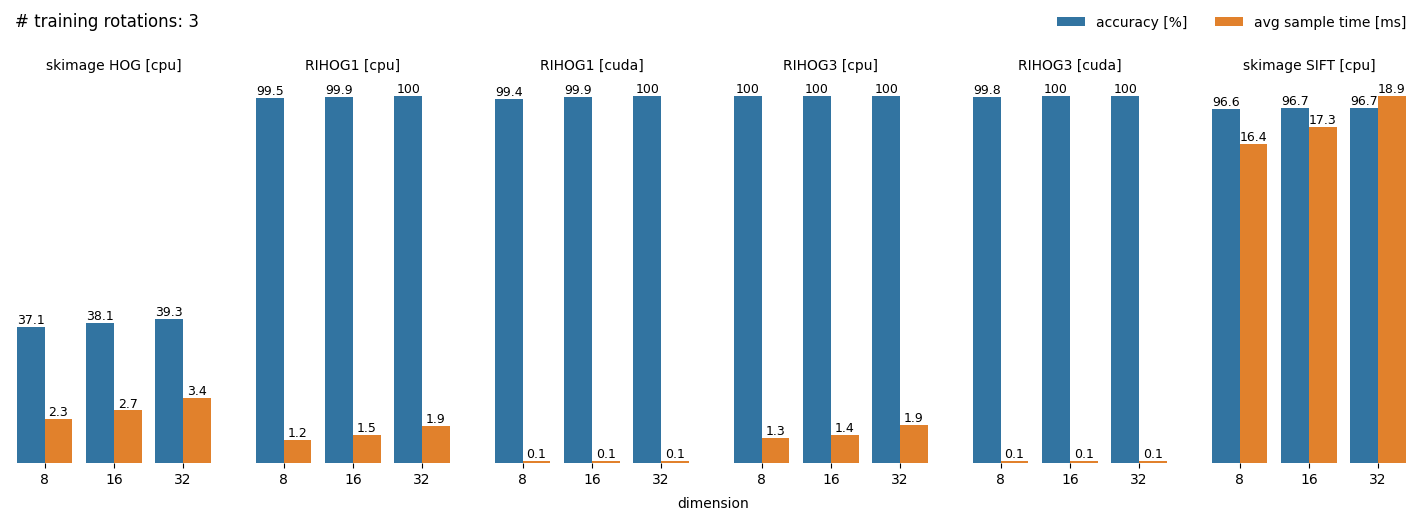

In [11]:
for n_train in df["n_train"].unique():
	g = sns.catplot(
		data=df_plot[df_plot["n_train"]==n_train], kind="bar",
		y="value", x="dim", hue="variable",
		col="algo",
		aspect=0.5
	)
	g.despine(left=True, bottom=True)
	g.tick_params(axis="y", left=False)
	g.set_titles(col_template="{col_name}")
	g.set_ylabels("")
	g.set_xlabels("")
	g.figure.suptitle(f"# training rotations: {n_train}", ha="left", x=.05, y=.99)
	g.figure.text(0.46, 0, "dimension", ha="center")
	g.figure.subplots_adjust(top=.86, bottom=.09, wspace=.15)
	for ax in g.axes.ravel():
		ax: plt.Axes
		ax.set_ylim(0, 105)
		ax.set_yticks([])
		ax.bar_label(ax.containers[0], fmt=lambda x: f"{x:.1f}".rstrip("0").rstrip("."), fontsize=9)
		ax.bar_label(ax.containers[1], fmt=lambda x: f"{x / time_scale:.1f}", fontsize=9)
	g.legend.remove()
	plt.legend(title=None, loc="upper right", bbox_to_anchor=(1.03, 1.195), frameon=False, ncols=4)